In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import StandardScaler
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

In [4]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

#scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

**3 VGGs + Increasing Dropout + Batch Normalization + Cosine Annealing**

In [5]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
 	# Cosine annealing 
	first_decay_steps = 1000
	initial_learning_rate = 0.001
	lr = CosineDecayRestarts(initial_learning_rate, first_decay_steps, t_mul=2.0, m_mul=1.0, alpha=0.0, name=None)
	# compile model
	opt = SGD(lr)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [6]:
def summarize_diagnostics(history):
	fig, (ax1, ax2) = pyplot.subplots(2)
	# plot loss
	ax1.set_title('Cross Entropy Loss')
	ax1.plot(history.history['loss'], color='blue', label='train')
	ax1.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	ax2.set_title('Classification Accuracy')
	ax2.plot(history.history['accuracy'], color='blue', label='train')
	ax2.plot(history.history['val_accuracy'], color='orange', label='test')
	fig.tight_layout()
	# save plot to file
	filename = 'Cosine Annealing'
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()


In [7]:
 
 # run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
	#model.save('final_model.h5')
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

> 62.840


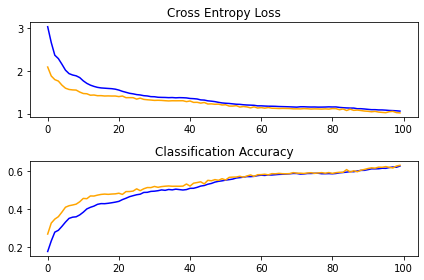

In [9]:
# entry point, run the test harness
run_test_harness()